In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import torch.nn as nn
from collections import deque
from tqdm.notebook import tqdm
import random
import math
from IPython.display import clear_output

# CartPole

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

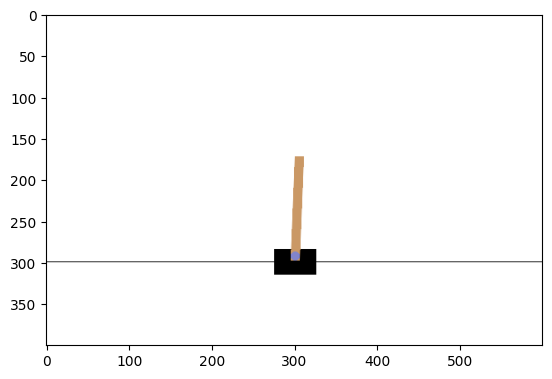

In [16]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())
plt.show()

In [3]:
class ReplayBuffer():
    def __init__(self,max_capacity = 2000,batch_size = 4):
        self.max_capacity = max_capacity
        self.buffer = deque(maxlen=max_capacity)
        self.batch_size = batch_size
        
    def add(self,state,action,reward,next_state,done):
        state = np.expand_dims(state,axis=0)
        next_state = np.expand_dims(next_state,axis=0)
        self.buffer.append([state,action,reward,next_state,done])
    def clear_histoy(self):
        self.buffer.clear()
        
    def get_batch(self):
        state,action,reward,next_state,done = zip(*random.sample(self.buffer,self.batch_size))
        return np.concatenate(state),action,reward,np.concatenate(next_state),done
    
    def __len__(self):
        return len(self.buffer)

In [18]:
class DQN(nn.Module):
    def __init__(self,n_actions,n_states):
        super(DQN,self).__init__()
        
        self.f = nn.Sequential(
            nn.Linear(n_states,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,n_actions)
        )
    def forward(self,state):
        action_value = self.f(state)
        return action_value
Q = DQN(2,4)

In [19]:
def select_action(state,epsilon = 1e-6):
    state = torch.from_numpy(state).unsqueeze(dim=0)
    if random.random() < epsilon:
        return np.random.randint(0,2)
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [20]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [4]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [22]:
def train(Q,static_Q,num_time_steps,env,batch_size,replay_buffer_size = 2000,gamma = 0.99,lr = 1e-4,start_train_at = 10000,avg_reward_for_solved=450,averaging_last=200):

    replay_buffer = ReplayBuffer(max_capacity=replay_buffer_size,batch_size=batch_size)
    optimizer = torch.optim.Adam(Q.parameters(),lr = lr)
    epsilon = 1.0
    reward_per_t = []
    losses = []
    t_reward = 0
    state,info = env.reset()
    for t in range(1,num_time_steps):
        epsilon = epsilon_by_frame(t)
        action = select_action(state,epsilon)
        next_state,reward,done,_,info = env.step(action)
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        t_reward+=reward
        if done:
            state,info = env.reset()
            reward_per_t.append(t_reward)
            t_reward =0
        
        
        if len(replay_buffer) > start_train_at:
            s,action,reward,next_state,done = replay_buffer.get_batch()
            s = torch.from_numpy(s).unsqueeze(dim=1).type(torch.float32).to(device)
            action = torch.tensor(action).to(device)
            reward = torch.tensor(reward).to(device)
            next_state = torch.from_numpy(next_state).unsqueeze(dim=1).type(torch.float32).to(device)
            not_done =torch.tensor(1-np.array(done)).to(device)
            next_max_value_action = torch.argmax(Q(next_state),dim=1)
            target = reward + not_done * gamma*static_Q(next_state).detach()[range(len(next_max_value_action)),next_max_value_action]
            prediction = Q(s)
            prediction = prediction[range(len(action)),action]
            loss = torch.nn.functional.mse_loss(prediction,target,reduction='mean')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if t % 200 == 0:
                static_Q.load_state_dict(Q.state_dict())
        if np.mean(reward_per_t[-averaging_last:]) > avg_reward_for_solved:
            print('Solved')
            break
        if t % 10000 == 0:
            plot(t,reward_per_t,losses)
            print(f'epsilon {epsilon:.2f}')

In [ ]:
Q = DQN(2,4).to(device)
static_Q = DQN(2,4).to(device)
static_Q.load_state_dict(Q.state_dict())

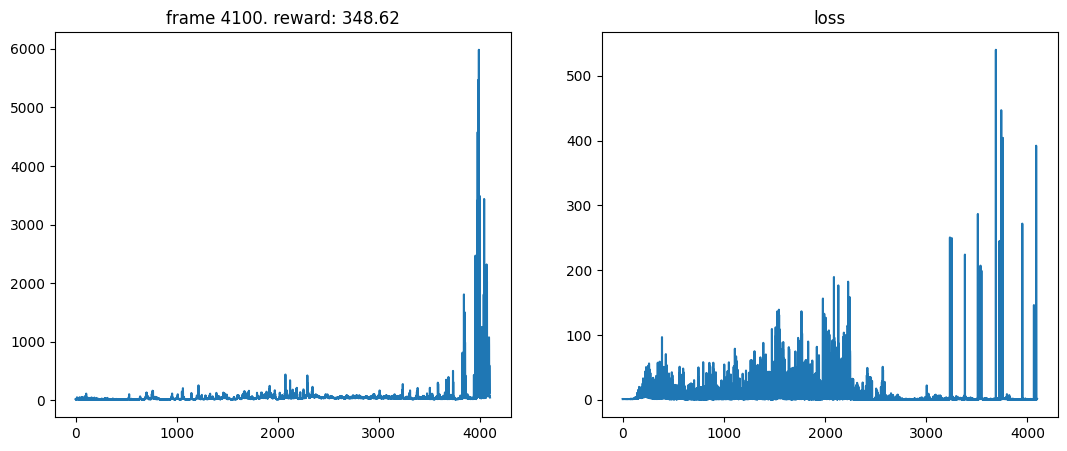

epsilon 0.01
DONE


In [23]:
train(Q,static_Q,100000,env,batch_size=16,replay_buffer_size=1000,gamma=0.99,lr=5e-4,avg_reward_for_solved=450,averaging_last=200,start_train_at=1000)

In [1]:
# env_2 = gym.make('CartPole-v1',render_mode = 'human')
# #env_2 = gym.wrappers.RecordVideo(env_2,'.',episode_trigger=lambda x:True)
# for episode in range(5):
#     state,info = env_2.reset()
#     rewards = 0
#     while True:
#         action = select_action(state,epsilon=0)
#         next_state,reward,done,_,info = env_2.step(action)
#         if done:
#             break
#         state = next_state
#         rewards+= reward
#     print('rewad',rewards)
# env_2.close()

# Atari Pong


In [5]:
from gymnasium.wrappers import AtariPreprocessing

actions Discrete(6)
observation Box(0, 255, (210, 160, 3), uint8)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/cerenov/anaconda3/envs/RL/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


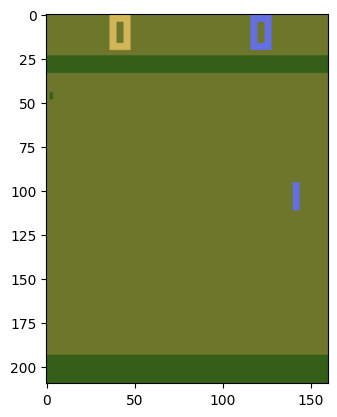

In [6]:
env = gym.make('PongNoFrameskip-v4',render_mode = 'rgb_array')
state,info = env.reset()
print('actions',env.action_space)
print('observation',env.observation_space)
plt.imshow(env.render())
plt.show()

In [7]:
class ConvDQN(nn.Module):
    def __init__(self,n_actions):
        super(ConvDQN,self).__init__()
        self.q = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=8,stride=4),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2592,256),
            nn.ReLU(),
            nn.Linear(256,n_actions)
        )
        
    def forward(self,state):
        q_value = self.q(state)
        return q_value

In [8]:

env = AtariPreprocessing(env,scale_obs=True,grayscale_newaxis=False,grayscale_obs=True)

In [9]:
def select_action(state,epsilon = 1e-6):
    
    state = torch.from_numpy(state).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    
    if random.random() < epsilon:
        return random.randrange(env.action_space.n)
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [10]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 40000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [ ]:
Q = ConvDQN(6).to(device)
static_Q = ConvDQN(6).to(device)
static_Q.load_state_dict(Q.state_dict())

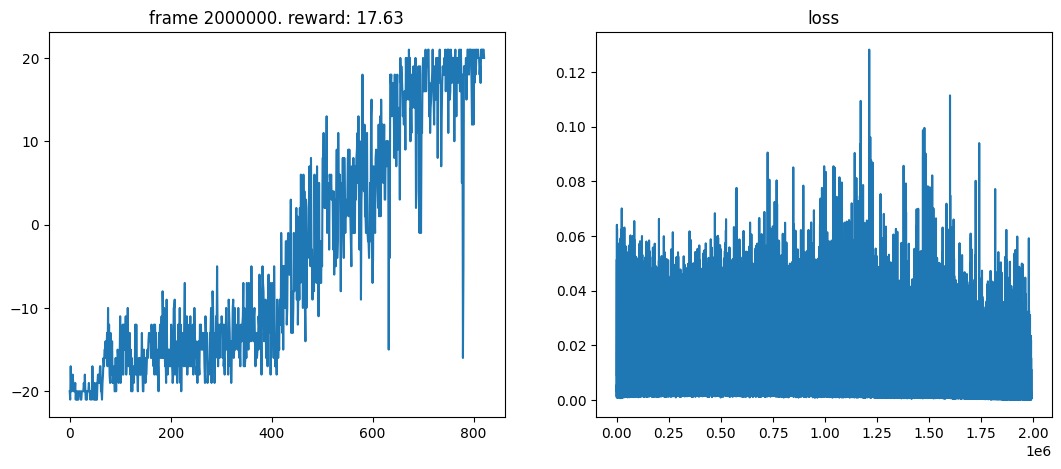

epsilon 0.01
Solved


In [14]:
train(Q,static_Q,10000000,env,batch_size=32,replay_buffer_size=100000,gamma=0.99,lr=5e-4,avg_reward_for_solved=20,averaging_last=10,start_train_at=10000)